In [ ]:
import pandas as pd
df = pd.read_csv("/content/Month_Value_1.csv")

In [ ]:
df

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...,...
91,01.08.2022,NaN,NaN,NaN,NaN
92,01.09.2022,NaN,NaN,NaN,NaN
93,01.10.2022,NaN,NaN,NaN,NaN
94,01.11.2022,NaN,NaN,NaN,NaN


In [ ]:
#Converting Period column to datetime
df['Period'].info()
df['Period'] = pd.to_datetime(df['Period'])
df['Period'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 96 entries, 0 to 95
Series name: Period
Non-Null Count  Dtype 
--------------  ----- 
96 non-null     object
dtypes: object(1)
memory usage: 900.0+ bytes
<class 'pandas.core.series.Series'>
RangeIndex: 96 entries, 0 to 95
Series name: Period
Non-Null Count  Dtype         
--------------  -----         
96 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 900.0 bytes


In [ ]:
df.isna().sum()

,0
Period,0
Revenue,32
Sales_quantity,32
Average_cost,32
The_average_annual_payroll_of_the_region,32


In [ ]:
# Drop rows with missing values
df = df.dropna()

In [ ]:
df

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,2015-01-01,1.601007e+07,12729.0,1257.763541,30024676.0
1,2015-01-02,1.580759e+07,11636.0,1358.507000,30024676.0
2,2015-01-03,2.204715e+07,15922.0,1384.697024,30024676.0
3,2015-01-04,1.881458e+07,15227.0,1235.606705,30024676.0
4,2015-01-05,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...,...
59,2019-01-12,5.875647e+07,38069.0,1543.420464,29878525.0
60,2020-01-01,5.628830e+07,27184.0,2070.640850,29044998.0
61,2020-01-02,4.022524e+07,23509.0,1711.057181,29044998.0
62,2020-01-03,5.002217e+07,32569.0,1535.882748,29044998.0


In [ ]:
#Removed data after 2019-12-01 because I want to evaluate the performance of the model in 12 months forecast
df = df[df['Period'] < '2020-01-01'] 
df

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,2015-01-01,1.601007e+07,12729.0,1257.763541,30024676.0
1,2015-01-02,1.580759e+07,11636.0,1358.507000,30024676.0
2,2015-01-03,2.204715e+07,15922.0,1384.697024,30024676.0
3,2015-01-04,1.881458e+07,15227.0,1235.606705,30024676.0
4,2015-01-05,1.402148e+07,8620.0,1626.621765,30024676.0
5,2015-01-06,1.678393e+07,13160.0,1275.374508,30024676.0
6,2015-01-07,1.916189e+07,17254.0,1110.576805,30024676.0
7,2015-01-08,1.520498e+07,8642.0,1759.428870,30024676.0
8,2015-01-09,2.060394e+07,16144.0,1276.259909,30024676.0
9,2015-01-10,2.099287e+07,18135.0,1157.588904,30024676.0


In [ ]:
df = df[['Period', 'Sales_quantity']].copy()

In [ ]:
df

,Period,Sales_quantity
0,2015-01-01,12729.0
1,2015-01-02,11636.0
2,2015-01-03,15922.0
3,2015-01-04,15227.0
4,2015-01-05,8620.0
5,2015-01-06,13160.0
6,2015-01-07,17254.0
7,2015-01-08,8642.0
8,2015-01-09,16144.0
9,2015-01-10,18135.0


In [ ]:
df_infer = df[df['Period'] < '2019-01-01']  # For inference
df_test = df[df['Period'] >= '2019-01-01'] # For evaluation

In [ ]:
df_infer

,Period,Sales_quantity
0,2015-01-01,12729.0
1,2015-01-02,11636.0
2,2015-01-03,15922.0
3,2015-01-04,15227.0
4,2015-01-05,8620.0
5,2015-01-06,13160.0
6,2015-01-07,17254.0
7,2015-01-08,8642.0
8,2015-01-09,16144.0
9,2015-01-10,18135.0


In [ ]:
df_test

,Period,Sales_quantity
48,2019-01-01,24096.0
49,2019-01-02,21624.0
50,2019-01-03,33379.0
51,2019-01-04,22265.0
52,2019-01-05,16967.0
53,2019-01-06,24958.0
54,2019-01-07,21917.0
55,2019-01-08,14431.0
56,2019-01-09,23253.0
57,2019-01-10,26603.0


In [ ]:
import torch
import numpy as np
from transformers import TimesFmModelForPrediction, TimesFmConfig


# Define the configuration for the TimesFM model
config = TimesFmConfig(
    patch_length=32,
    context_length=512,      # Length of input context
    horizon_length=128,     # Length of prediction horizon
    freq_size=3,            # 0: High, 1: Medium, 2: Low
    num_hidden_layers=50,   # Number of Transformer layers
    hidden_size=1280,       # Size of hidden layers
    intermediate_size=1280,
    num_attention_heads=16,
    head_dim=80,
    quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
)


model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    config=config,           # Used the config defined above
    dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="auto"
)


forecast_input = [df_infer["Sales_quantity"].values.astype(np.float32)]
frequency_input = [2]  #0 for daily data, 1 for weekly, 2 for monthly

forecast_input_tensor = [
    torch.tensor(ts, dtype=torch.bfloat16).to(model.device)
    for ts in forecast_input
]
frequency_input_tensor = torch.tensor(frequency_input, dtype=torch.long).to(model.device)

with torch.no_grad():
    outputs = model(
        past_values=forecast_input_tensor,
        freq=frequency_input_tensor,
        return_dict=True
    )
    point_forecast = outputs.mean_predictions.float().cpu().numpy()

print("Point forecast shape:", point_forecast.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/813 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/timesfm/modeling_timesfm.py:642: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(freq[: len(inputs)], dtype=torch.int32).reshape(-1, 1),


Point forecast shape: (1, 128)


In [ ]:
print(point_forecast[:, :12])

[[24832. 21248. 27264. 21760. 17536. 22144. 21248. 15616. 24064. 24064.
  19968. 30848.]]


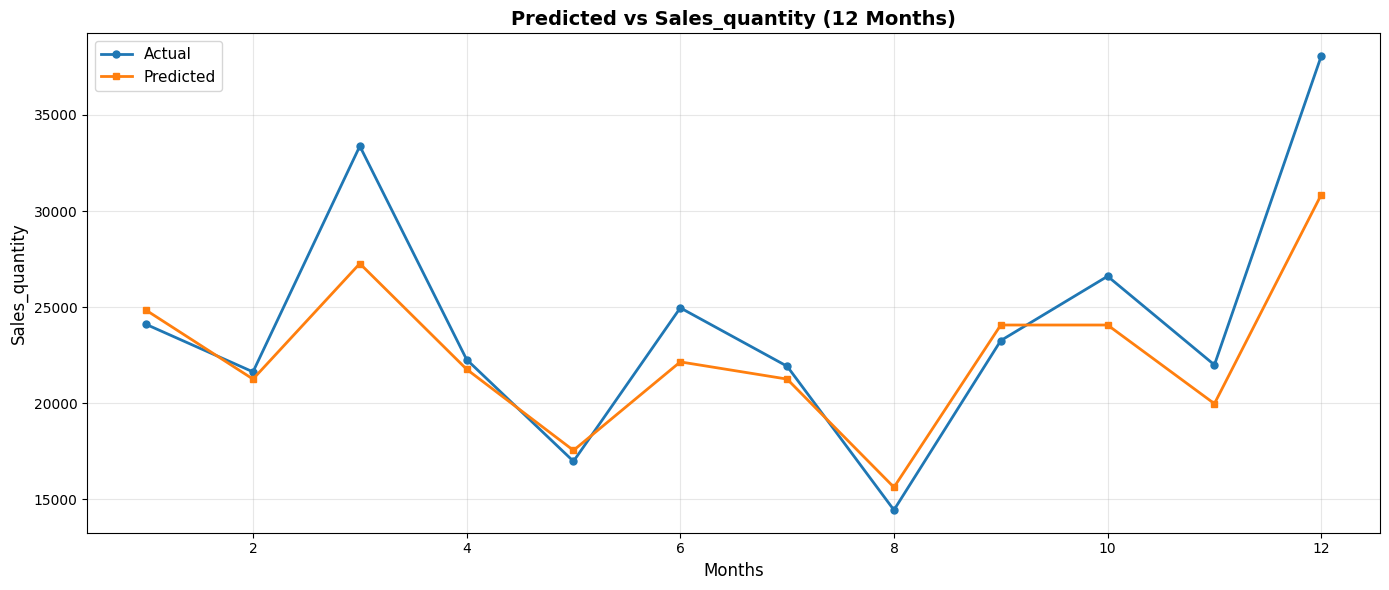

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get actual values
actual = df_test['Sales_quantity'].values

# Get predicted values
predicted = point_forecast[:, :12].flatten()

# Create x-axis (days)
days = np.arange(1, 13)

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(days, actual, label='Actual', marker='o', linewidth=2, markersize=5)
plt.plot(days, predicted, label='Predicted', marker='s', linewidth=2, markersize=5)

plt.xlabel('Months', fontsize=12)
plt.ylabel('Sales_quantity', fontsize=12)
plt.title('Predicted vs Sales_quantity (12 Months)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()